In [1]:
!git clone https://github.com/openai/shap-e

Cloning into 'shap-e'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 336 (delta 41), reused 218 (delta 18), pack-reused 76 (from 1)
Receiving objects: 100% (336/336), 11.72 MiB | 8.38 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [2]:
%cd shap-e

/content/shap-e


In [3]:
!pip install -e .
!pip install googletrans==4.0.0-rc1
!pip install matplotlib
!pip install scikit-learn

Obtaining file:///content/shap-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-9_0y4ckl/clip_c82cdc0ace1044b4a2fe18b148c9937c
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-9_0y4ckl/clip_c82cdc0ace1044b4a2fe18b148c9937c
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=e1b1851a3dac05d96aebac0c1261cef4845911067886dfdc4ac9f490181d3062
  Stored in directory:

In [4]:
import torch
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from googletrans import Translator
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [6]:
# Выбор устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Вывод сообщения о выбранном устройстве
if device.type == 'cuda':
    print(f"Выбрано устройство: {device.type.upper()} (GPU)")
else:
    print(f"Выбрано устройство: {device.type.upper()} (CPU)")

Выбрано устройство: CUDA (GPU)


In [7]:
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))
# Создаем объект переводчика
translator = Translator()

# Функция для перевода текста с русского на английский
def translate_to_english(text):
    translation = translator.translate(text, src='ru', dest='en')
    return translation.text

/content/shap-e/shap_e/models/nn/checkpoint.py:32: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length, *args):
/content/shap-e/shap_e/models/nn/checkpoint.py:44: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *output_grads):
/content/shap-e/shap_e/models/nn/checkpoint.py:62: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length_1, length_2, *args):
/content/shap-e/shap_e/models/nn/checkpoint.py:87: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *all_output_grads):


  0%|          | 0.00/1.78G [00:00<?, ?iB/s]

/content/shap-e/shap_e/models/download.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)
100%|██████████████████████████████

  0%|          | 0.00/1.26G [00:00<?, ?iB/s]

/content/shap-e/shap_e/models/download.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


In [8]:
batch_size = 1
guidance_scale = 15.0
prompt = "a red plane"

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
).to(device)  # Перемещаем латентные представления на устройство CUDA

  0%|          | 0/64 [00:00<?, ?it/s]

In [9]:
render_mode = 'nerf'
size = 64 # это размер рендера; более высокие значения займут больше времени для рендера.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    images = decode_latent_images(xm, latent.to(device), cameras, rendering_mode=render_mode)  # Перемещаем латентные представления на устройство CUDA
    display(gif_widget(images))

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAALGml66ej7OQf7l2Z80oEMoIAuYAAOUAAOQAAOMAAOIAAOEAAO…

  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAE5RT01RTk5QTk1QTk1QTUxQTU1PTUxPTUxPTEtPTExOTUtOTU…

GIF сохранен в generated_gif.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

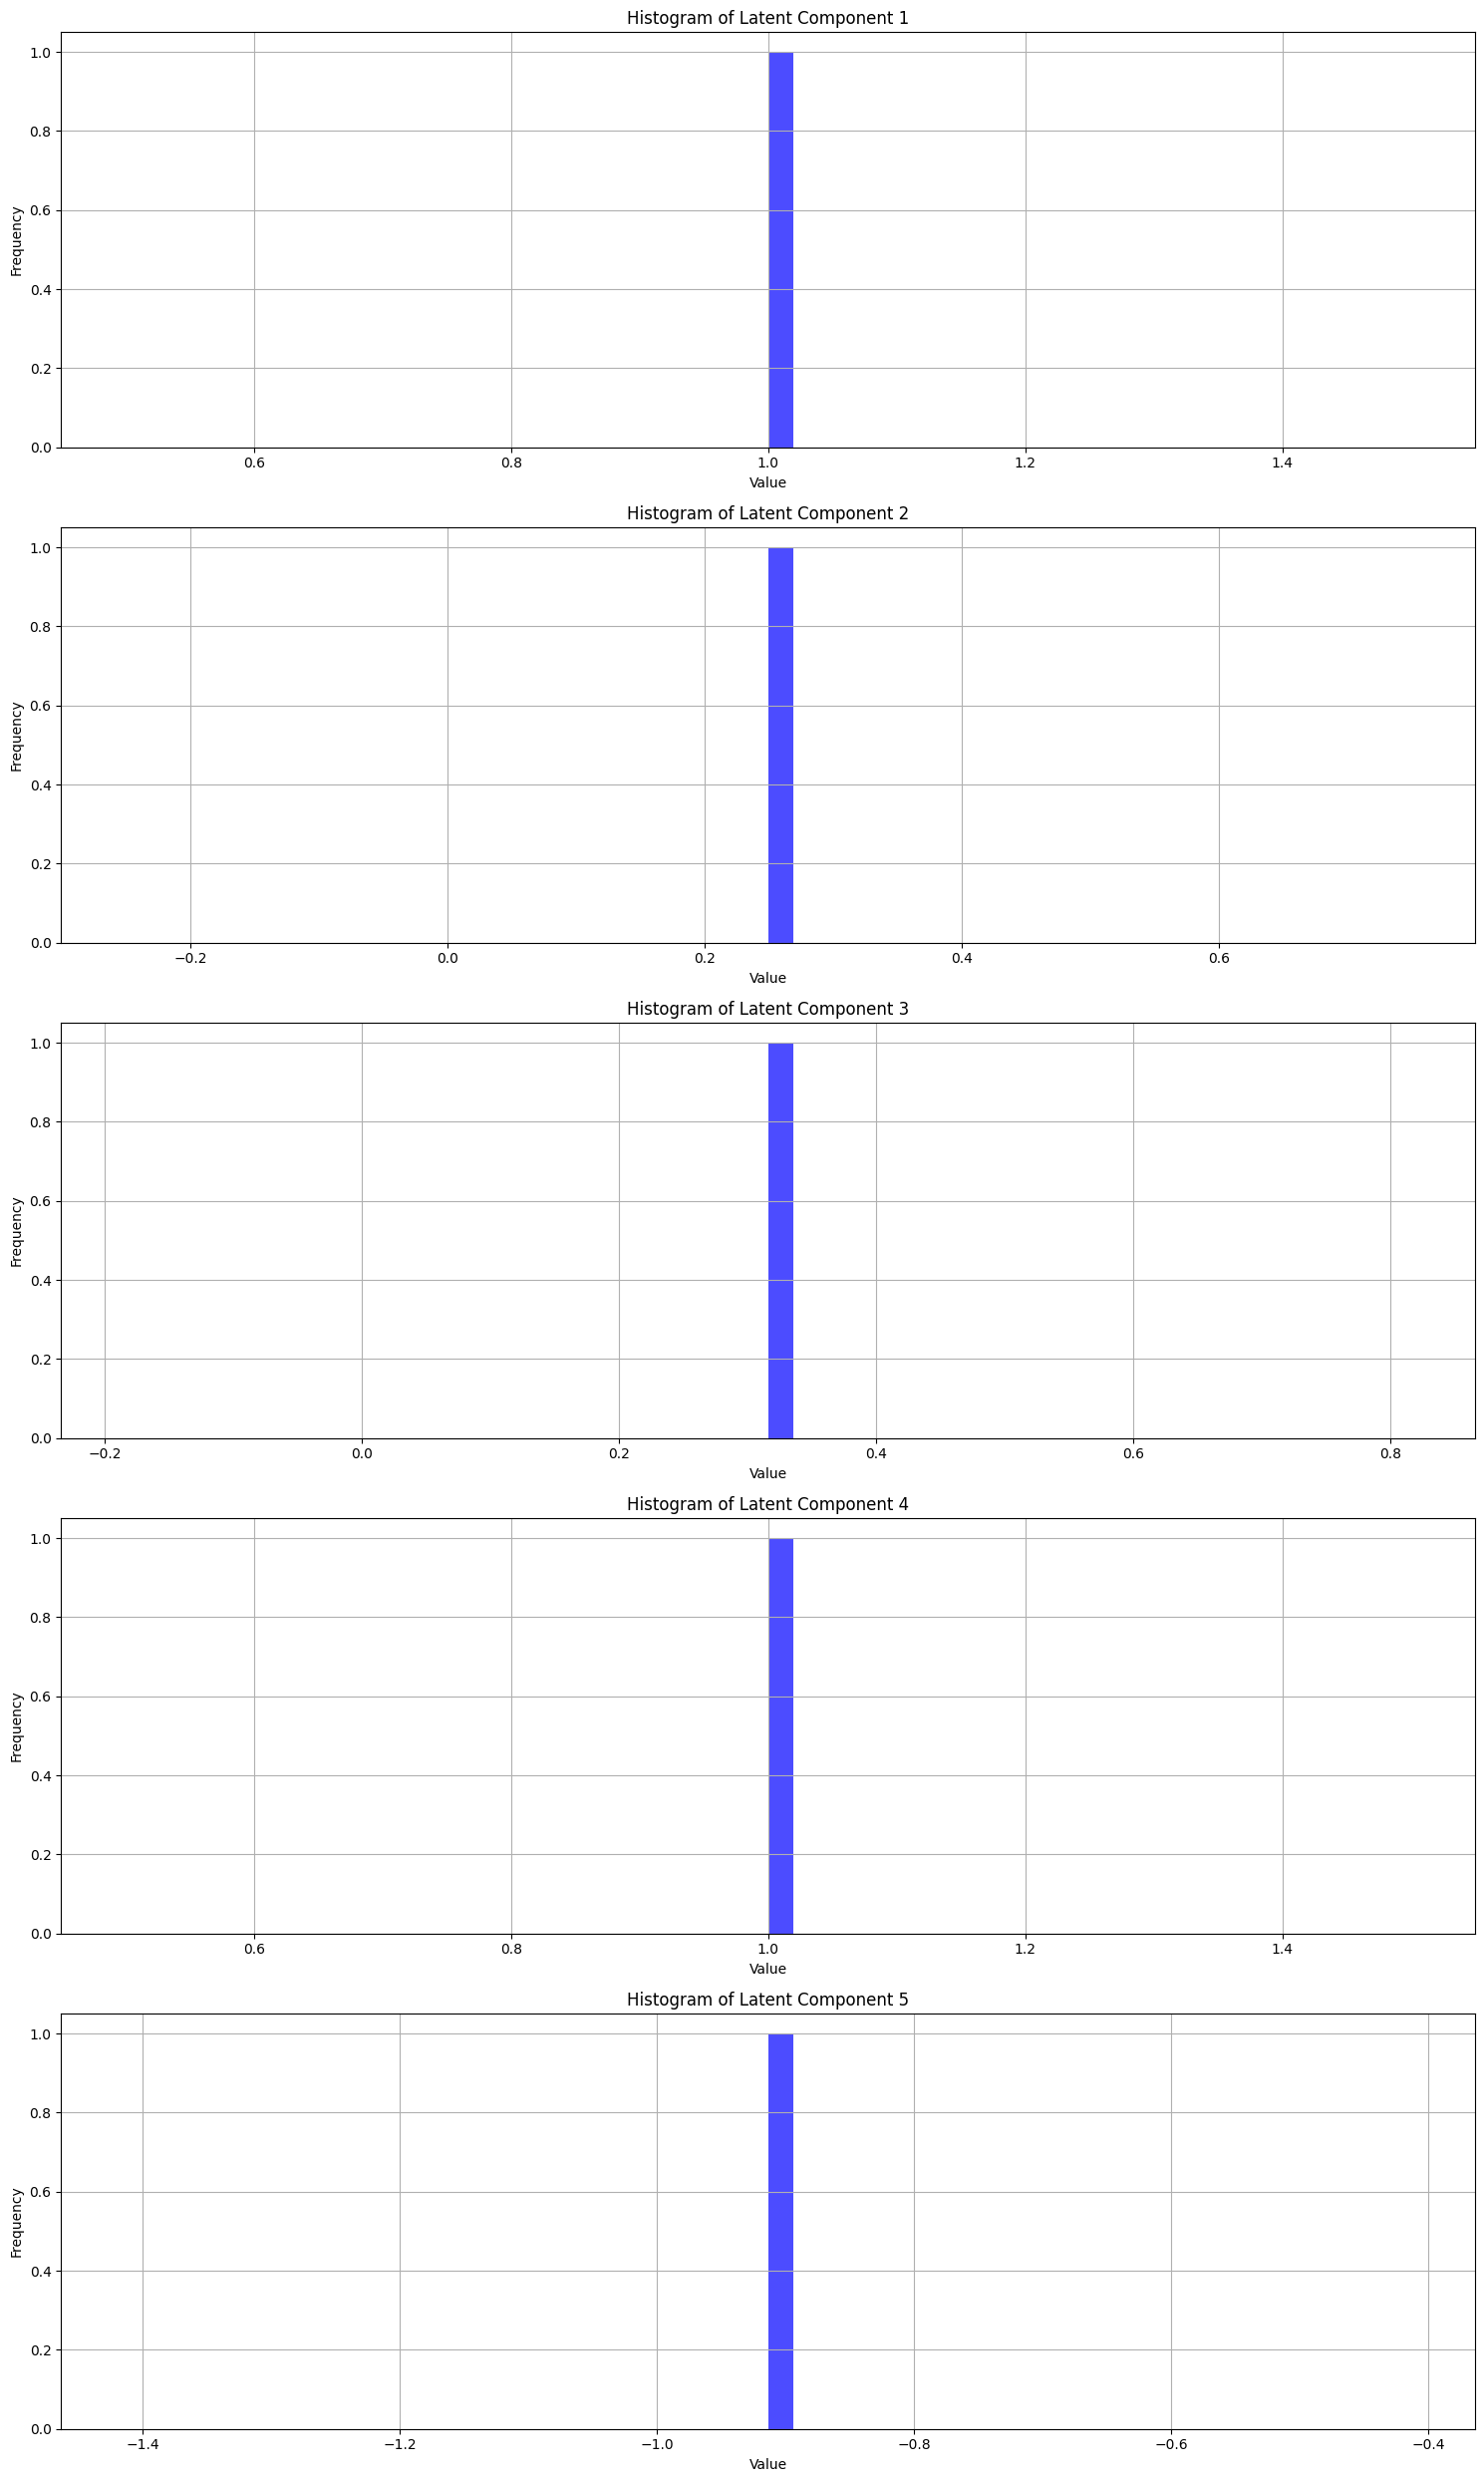

In [10]:
# Инициализация переводчика
translator = Translator()

# Функция для перевода текста с русского на английский
def translate_to_english(text):
    translation = translator.translate(text, src='ru', dest='en')
    return translation.text

# Функция для округления размера до ближайшего кратного 8
def round_to_nearest_multiple(value, multiple):
    return (value + multiple - 1) // multiple * multiple

# Создание виджетов для ввода параметров
prompt_widget = widgets.Text(value='красный самолет', description='Prompt:', disabled=False)
guidance_scale_widget = widgets.FloatSlider(value=15.0, min=1.0, max=30.0, step=0.1, description='Guidance Scale:', disabled=False)
render_mode_widget = widgets.Dropdown(options=['nerf', 'stf'], value='nerf', description='Render Mode:', disabled=False)
size_widget = widgets.IntSlider(value=64, min=32, max=256, step=8, description='Size:', disabled=False)
diffusion_steps_widget = widgets.IntSlider(value=64, min=1, max=256, step=1, description='Diffusion Steps:', disabled=False)
batch_size_widget = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Batch Size:', disabled=False)

# Создание кнопки для начала генерации
generate_button = widgets.Button(description="Generate")

# Создание кнопки для сохранения GIF
save_button = widgets.Button(description="Save GIF")

# Создание кнопки для отображения гистограммы
histogram_button = widgets.Button(description="Show Histogram")

# Инициализация переменных для хранения сгенерированных изображений и латентных представлений
generated_images = []
generated_latents = None

# Определение функции, которая будет вызываться при нажатии на кнопку генерации
def on_generate_button_clicked(b):
    global generated_images, generated_latents
    prompt = prompt_widget.value
    translated_prompt = translate_to_english(prompt)
    guidance_scale = guidance_scale_widget.value
    render_mode = render_mode_widget.value
    size = round_to_nearest_multiple(size_widget.value, 8)  # Округление размера до ближайшего кратного 8
    diffusion_steps = diffusion_steps_widget.value
    batch_size = batch_size_widget.value

    latents = sample_latents(
        batch_size=batch_size,
        model=model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(texts=[translated_prompt] * batch_size),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=diffusion_steps,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    ).to(device)  # Перемещаем латентные представления на устройство CUDA

    generated_latents = latents

    cameras = create_pan_cameras(size, device)
    generated_images = []
    for i, latent in enumerate(latents):
        images = decode_latent_images(xm, latent.to(device), cameras, rendering_mode=render_mode)  # Перемещаем латентные представления на устройство CUDA
        generated_images.append(images)
        display(gif_widget(images))

# Определение функции, которая будет вызываться при нажатии на кнопку сохранения
def on_save_button_clicked(b):
    if generated_images:
        output_path = 'generated_gif.gif'
        imageio.mimsave(output_path, generated_images[0], fps=10)
        print(f"GIF сохранен в {output_path}")
        # Создание ссылки для скачивания сохраненного GIF
        files.download(output_path)
    else:
        print("Изображения еще не сгенерированы. Пожалуйста, сначала сгенерируйте изображения.")

# Функция для визуализации латентных представлений
def visualize_latents(latents):
    # Проверка размерности латентных представлений
    if latents.ndimension() == 1:
        # Если латентные представления одномерные, визуализируем их гистограмму
        plt.figure(figsize=(10, 5))
        plt.hist(latents.cpu().numpy(), bins=50, color='blue', alpha=0.7)
        plt.title('Histogram of Latent Representations')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        # Если латентные представления многомерные, визуализируем гистограммы для каждого компонента
        num_components = min(latents.shape[1], 5)  # Визуализируем первые 5 компонентов
        plt.figure(figsize=(15, 5 * num_components))
        for i in range(num_components):
            plt.subplot(num_components, 1, i + 1)
            plt.hist(latents[:, i].cpu().numpy(), bins=50, color='blue', alpha=0.7)
            plt.title(f'Histogram of Latent Component {i + 1}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

# Определение функции, которая будет вызываться при нажатии на кнопку отображения гистограммы
def on_histogram_button_clicked(b):
    if generated_latents is not None:
        visualize_latents(generated_latents)
    else:
        print("Латентные представления еще не сгенерированы. Пожалуйста, сначала сгенерируйте изображения.")

# Привязка функций к кнопкам
generate_button.on_click(on_generate_button_clicked)
save_button.on_click(on_save_button_clicked)
histogram_button.on_click(on_histogram_button_clicked)

# Создание разделов для организации интерфейса
input_section = widgets.VBox([prompt_widget, guidance_scale_widget, render_mode_widget, size_widget, diffusion_steps_widget, batch_size_widget])
button_section = widgets.HBox([generate_button, save_button, histogram_button])

# Отображение виджетов и кнопок
display(input_section, button_section)